In [1]:
#!pip install tensorflow

In [2]:
#!pip install scikit-learn

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

2023-03-17 13:52:37.508099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 13:52:38.132636: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-17 13:52:38.132707: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-17 13:52:38.132713: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
#Import svm model
from sklearn import svm
from sklearn import metrics

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
features = pd.read_pickle("feat_umbrella.pickle")

In [5]:
features.head()

,main_fg_tokens,main_consistent_fg_token,second_fg_tokens,second_consistent_fg_token,layer_11_act,layer_10_act,layer_09_act,class
0,"[{'max_image': 44, 'max_obj': 48, 'min_obj': 1...",48,"[{'max_image': 44, 'max_obj': 20, 'min_obj': 3...",21,"[[1.826385, -3.5232038, 5.57924, 3.1996312, -2...","[[1.5222354, -1.4939439, 1.1973153, 0.7007799,...","[[2.1527548, 0.31304604, 0.96389973, -0.273574...",umbrella
1,"[{'max_image': 73, 'max_obj': 139, 'min_obj': ...",139,"[{'max_image': 73, 'max_obj': 73, 'min_obj': 8...",73,"[[4.3050046, -0.46489114, -1.8229105, 6.588824...","[[1.4656473, -0.51247597, -1.076628, 4.168139,...","[[1.0357955, -0.87308025, -0.09360698, 3.40280...",umbrella
2,"[{'max_image': 13, 'max_obj': 122, 'min_obj': ...",122,"[{'max_image': 13, 'max_obj': 132, 'min_obj': ...",133,"[[3.2517006, 1.3580538, 0.09049022, -0.4365451...","[[5.392159, 0.010011062, -1.209736, 0.269333, ...","[[5.0641985, -0.72485566, -0.52403384, 0.52894...",umbrella
3,"[{'max_image': 169, 'max_obj': 111, 'min_obj':...",83,"[{'max_image': 169, 'max_obj': 57, 'min_obj': ...",71,"[[2.182576, -4.5960045, 0.15199006, 0.25316972...","[[2.8003109, -2.7597106, -1.1758456, 0.4109611...","[[3.6498787, -1.9236376, -1.2405375, -0.642870...",umbrella
4,"[{'max_image': 178, 'max_obj': 34, 'min_obj': ...",34,"[{'max_image': 178, 'max_obj': 7, 'min_obj': 1...",19,"[[3.0315478, -5.5101504, 1.5613348, 3.1828115,...","[[1.1368338, -2.7410648, -0.19420055, 0.345808...","[[0.05278492, -1.6149038, 0.5943533, 0.4209689...",umbrella


In [4]:
labels = ['umbrella', 'tie', 'suitcase']
# labels = ['backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'bottle', 'cup', 'fork', 'knife', 'bowl', 'chair']
# (1, 27) ('person', 'backpack'): 3524
# (1, 28) ('person', 'umbrella'): 2089
# (1, 31) ('person', 'handbag'): 4890
# (1, 32) ('person', 'tie'): 1543
# (1, 33) ('person', 'suitcase'): 1048
labels_to_idx = dict(zip(labels, range(len(labels))))
labels_to_idx

{'umbrella': 0, 'tie': 1, 'suitcase': 2}

In [7]:
features["labels"] = features['class'].apply(lambda x: labels_to_idx[x])

In [8]:
len(features)

538

In [9]:
features = features[(~features["second_fg_tokens"].isnull()) & (~features["main_fg_tokens"].isnull())]
features = features.reset_index(drop=True)
len(features)

538

In [10]:
token_strategy = 'max_obj'
layer = 0

In [11]:
token = features["main_fg_tokens"][0][layer][token_strategy]
x = features["layer_11_act"][0][token,:]
print(x.shape)
y = to_categorical(features["labels"].values.tolist())
print(y.shape)

(768,)
(538, 1)


In [12]:
x = np.zeros((len(features),768))
print(x.shape)
for idx, row in features.iterrows():
    token = row["main_fg_tokens"][layer][token_strategy]
    x[idx] = row["layer_09_act"][token,:]

(538, 768)


In [13]:
x.shape

(538, 768)

In [5]:
def base_model(model="NN"):
    if model == "NN":
        clf_model = Sequential()
        clf_model.add(Dense(256, input_dim=768, activation='relu'))
        clf_model.add(Dropout(0.5))
        clf_model.add(Dense(3))
        clf_model.add(Activation("softmax"))

    #     sgd = SGD(lr=0.001)
        adam = Adam()
        clf_model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
    else:
        clf_model = svm.SVC(kernel='linear') # Linear Kernel
    return clf_model

In [6]:
# files = ["feat_backpack.pickle", "feat_handbag.pickle", "feat_suitcase.pickle", "feat_tie.pickle", "feat_umbrella.pickle"]
files = ["feat_full_act_suitcase.pickle", "feat_full_act_tie.pickle", "feat_full_act_umbrella.pickle"]

features = pd.DataFrame()
for file in files:
    print(f"Processing file '{file}'")
    features = pd.concat([features, pd.read_pickle(file)[:1000]])
# TODO: fix consistent token selection with multiple layers
features = features[(~features["second_fg_tokens"].isnull()) & 
                    (~features["main_fg_tokens"].isnull())
#                     (~features["second_consistent_fg_token"].isnull()) &
#                     (~features["main_consistent_fg_token"].isnull())
                   ]
features["labels"] = features['class'].apply(lambda x: labels_to_idx[x])
features = features.reset_index(drop=True)
len(features)   

Processing file 'feat_full_act_suitcase.pickle'
Processing file 'feat_full_act_tie.pickle'
Processing file 'feat_full_act_umbrella.pickle'


1017

In [21]:
token_strategies = ['max_image', 'max_obj', 'min_obj', 'random_obj']
# layer_strategy = 0
# layers_map = {0: '09', 1: '10', 2: '11'}
layers = [2,3,4,9,10,11]
# layers = [9,10,11]
objects = ['main', 'second']
model = "NN"
          
x = np.zeros((len(features),768))
y = np.zeros((len(features),1))
# samples_i = 0

histories = {}
test_scores = {}
for obj in objects:
    for strategy in token_strategies:
        for layer in layers:
            for idx, row in tqdm(features.iterrows()):
                if strategy == 'consistent':
                    token = int(row[f"{obj}_consistent_fg_token"])
                else:
                    token = int(row[f"{obj}_fg_tokens"][layer][strategy])

                x[idx] = row[f"layers_act"][layer][token,:]
                y[idx] = row["labels"]
#                 samples_i += 1    

#             x = x[:samples_i,:]
#             y = y[:samples_i,:]

            train_data, test_data, train_labels, test_labels = train_test_split(x, y, test_size=0.10, 
                                                                                stratify=y,
                                                                                random_state=42, 
                                                                                shuffle=True)    
            if model=="NN":
                train_labels = to_categorical(train_labels)
                test_labels = to_categorical(test_labels)
                
            clf_model = base_model(model)
            print(f"Training model: {layer}-{obj}-{strategy}")
            if model == "NN":                            
                hist = clf_model.fit(tf.stack(train_data), 
                                 tf.stack(train_labels), 
                                 validation_split=0.10,
                                 epochs=30, 
                                 batch_size=128, 
                                 verbose=0)
                histories[f"{layer}-{obj}-{strategy}"] = hist
                print("Evaluating model...")
                test_scores[f"{layer}-{obj}-{strategy}"] = clf_model.evaluate(tf.stack(test_data), tf.stack(test_labels), batch_size=len(test_data))
                print("Done...")
            else: 
                clf_model.fit(train_data, train_labels)
                y_pred = clf_model.predict(test_data)
                test_scores[f"{layer}-{obj}-{strategy}"] = metrics.accuracy_score(test_labels, y_pred)

1017it [00:00, 20823.48it/s]


Training model: 2-main-max_image
Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 1.7661 - accuracy: 0.4510
Done...


1017it [00:00, 12844.62it/s]

Training model: 3-main-max_image


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 1.1366 - accuracy: 0.5784
Done...


1017it [00:00, 12976.02it/s]

Training model: 4-main-max_image


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 1.2012 - accuracy: 0.5882
Done...


1017it [00:00, 23048.86it/s]


Training model: 9-main-max_image
Evaluating model...
1/1 [==============================] - 0s 16ms/step - loss: 1.0645 - accuracy: 0.7353
Done...


1017it [00:00, 25165.53it/s]

Training model: 10-main-max_image


Evaluating model...
1/1 [==============================] - 0s 16ms/step - loss: 1.0544 - accuracy: 0.8039
Done...


1017it [00:00, 22176.62it/s]

Training model: 11-main-max_image


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 0.4069 - accuracy: 0.9216
Done...


1017it [00:00, 13430.08it/s]

Training model: 2-main-max_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 1.3142 - accuracy: 0.5784
Done...


1017it [00:00, 24609.60it/s]

Training model: 3-main-max_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 1.2741 - accuracy: 0.6373
Done...


1017it [00:00, 24849.02it/s]

Training model: 4-main-max_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 1.0867 - accuracy: 0.6667
Done...


1017it [00:00, 24959.52it/s]

Training model: 9-main-max_obj


Evaluating model...
1/1 [==============================] - 0s 14ms/step - loss: 1.9230 - accuracy: 0.8039
Done...


1017it [00:00, 24603.78it/s]

Training model: 10-main-max_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 1.6841 - accuracy: 0.8529
Done...


1017it [00:00, 25131.28it/s]

Training model: 11-main-max_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 0.3667 - accuracy: 0.9608
Done...


1017it [00:00, 15031.44it/s]

Training model: 2-main-min_obj


Evaluating model...
1/1 [==============================] - 0s 14ms/step - loss: 1.3456 - accuracy: 0.5294
Done...


1017it [00:00, 12993.33it/s]

Training model: 3-main-min_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 1.0813 - accuracy: 0.6078
Done...


1017it [00:00, 13013.07it/s]

Training model: 4-main-min_obj


Evaluating model...
1/1 [==============================] - 0s 14ms/step - loss: 1.2395 - accuracy: 0.6471
Done...


1017it [00:00, 18385.84it/s]

Training model: 9-main-min_obj


Evaluating model...
1/1 [==============================] - 0s 14ms/step - loss: 0.8954 - accuracy: 0.7745
Done...


1017it [00:00, 13059.77it/s]

Training model: 10-main-min_obj


Evaluating model...
1/1 [==============================] - 0s 14ms/step - loss: 1.2285 - accuracy: 0.8627
Done...


1017it [00:00, 16402.71it/s]

Training model: 11-main-min_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 0.5798 - accuracy: 0.9510
Done...


1017it [00:00, 15442.34it/s]

Training model: 2-main-random_obj


Evaluating model...
1/1 [==============================] - 0s 14ms/step - loss: 1.3666 - accuracy: 0.5294
Done...


1017it [00:00, 23917.46it/s]

Training model: 3-main-random_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 1.3046 - accuracy: 0.6078
Done...


1017it [00:00, 12880.84it/s]

Training model: 4-main-random_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 1.0048 - accuracy: 0.6176
Done...


1017it [00:00, 13034.86it/s]

Training model: 9-main-random_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 0.7502 - accuracy: 0.7941
Done...


1017it [00:00, 12978.15it/s]

Training model: 10-main-random_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 0.8257 - accuracy: 0.8235
Done...


1017it [00:00, 25083.40it/s]

Training model: 11-main-random_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 0.7779 - accuracy: 0.9314
Done...


1017it [00:00, 12814.09it/s]

Training model: 2-second-max_image


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 1.6322 - accuracy: 0.4804
Done...


1017it [00:00, 12854.14it/s]

Training model: 3-second-max_image


Evaluating model...
1/1 [==============================] - 0s 14ms/step - loss: 1.1462 - accuracy: 0.6078
Done...


1017it [00:00, 16941.33it/s]

Training model: 4-second-max_image


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 1.2818 - accuracy: 0.6275
Done...


1017it [00:00, 18936.46it/s]

Training model: 9-second-max_image


Evaluating model...
1/1 [==============================] - 0s 14ms/step - loss: 1.0303 - accuracy: 0.7059
Done...


1017it [00:00, 12956.86it/s]

Training model: 10-second-max_image


Evaluating model...
1/1 [==============================] - 0s 14ms/step - loss: 1.1115 - accuracy: 0.7843
Done...


1017it [00:00, 23046.75it/s]

Training model: 11-second-max_image


Evaluating model...
1/1 [==============================] - 0s 14ms/step - loss: 0.3940 - accuracy: 0.9118
Done...


1017it [00:00, 13053.21it/s]

Training model: 2-second-max_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 0.8601 - accuracy: 0.7843
Done...


1017it [00:00, 25345.11it/s]

Training model: 3-second-max_obj


Evaluating model...
1/1 [==============================] - 0s 14ms/step - loss: 0.6069 - accuracy: 0.7843
Done...


1017it [00:00, 12764.09it/s]

Training model: 4-second-max_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 0.5724 - accuracy: 0.8039
Done...


1017it [00:00, 24621.96it/s]

Training model: 9-second-max_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 0.2760 - accuracy: 0.9216
Done...


1017it [00:00, 21655.47it/s]

Training model: 10-second-max_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 0.7319 - accuracy: 0.9412
Done...


1017it [00:00, 24882.36it/s]

Training model: 11-second-max_obj


Evaluating model...
1/1 [==============================] - 0s 14ms/step - loss: 0.2847 - accuracy: 0.9804
Done...


1017it [00:00, 16708.35it/s]

Training model: 2-second-min_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 0.9550 - accuracy: 0.7255
Done...


1017it [00:00, 12899.15it/s]

Training model: 3-second-min_obj


Evaluating model...
1/1 [==============================] - 0s 14ms/step - loss: 0.9914 - accuracy: 0.7353
Done...


1017it [00:00, 12930.24it/s]

Training model: 4-second-min_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 0.8340 - accuracy: 0.7647
Done...


1017it [00:00, 12846.40it/s]

Training model: 9-second-min_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 0.2792 - accuracy: 0.9216
Done...


1017it [00:00, 15296.86it/s]

Training model: 10-second-min_obj


Evaluating model...
1/1 [==============================] - 0s 16ms/step - loss: 0.2764 - accuracy: 0.9706
Done...


1017it [00:00, 12513.88it/s]

Training model: 11-second-min_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 0.3758 - accuracy: 0.9804
Done...


1017it [00:00, 14916.80it/s]

Training model: 2-second-random_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 0.9741 - accuracy: 0.7255
Done...


1017it [00:00, 21506.65it/s]

Training model: 3-second-random_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 0.8923 - accuracy: 0.7843
Done...


1017it [00:00, 25099.34it/s]

Training model: 4-second-random_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 0.6695 - accuracy: 0.8137
Done...


1017it [00:00, 13017.32it/s]

Training model: 9-second-random_obj


Evaluating model...
1/1 [==============================] - 0s 18ms/step - loss: 0.6014 - accuracy: 0.8824
Done...


1017it [00:00, 16773.39it/s]

Training model: 10-second-random_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 0.4515 - accuracy: 0.9412
Done...


1017it [00:00, 15703.91it/s]

Training model: 11-second-random_obj


Evaluating model...
1/1 [==============================] - 0s 15ms/step - loss: 0.1419 - accuracy: 0.9804
Done...


In [22]:
len(histories.keys())

48

In [23]:
len(test_scores.keys())

48

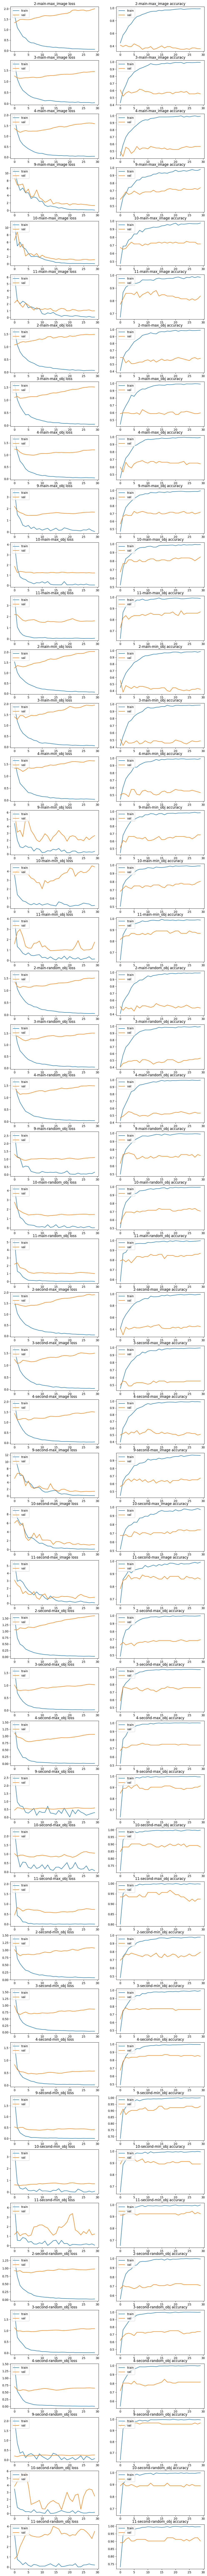

In [25]:
fig, axs = plt.subplots(nrows=48, ncols=2, figsize=(12, 160))
for idx, (layer_name, hist) in enumerate(histories.items()):
    axs[idx, 0].plot(hist.history['loss'])
    axs[idx, 0].plot(hist.history['val_loss'])
    axs[idx, 0].set_title(f'{layer_name} loss')
#     axs[idx, 0].ylabel('loss')
#     axs[idx, 0].xlabel('epoch')
    axs[idx, 0].legend(['train', 'val'], loc='upper left')

    axs[idx, 1].plot(hist.history['accuracy'])
    axs[idx, 1].plot(hist.history['val_accuracy'])
    axs[idx, 1].set_title(f'{layer_name} accuracy')
#     axs[idx, 1].ylabel('accuracy')
#     axs[idx, 1].xlabel('epoch')
    axs[idx, 1].legend(['train', 'val'], loc='upper left')

plt.show()

### Classification task summary:
* Number of instances per tuple, before cleaning. **Total 5 classes**.
    * (1, 27) ('person', 'backpack'): 3524
    * (1, 28) ('person', 'umbrella'): 2089
    * (1, 31) ('person', 'handbag'): 4890
    * (1, 32) ('person', 'tie'): 1543
    * (1, 33) ('person', 'suitcase'): 1048
* I had to limit the number of instances processed to 1000 because the extracted Tensor (hiddden states from 3 layers) became too big (5GB per tuple)
* from 5000 images, there were some issues with token selection and in the end **I was able to extract 2969 hidden states.**
    * these hidden states are from layers 10, 11 e 12 (3 last layers)
    * 10% split to test, 10% for validation
* Then, 30 NN were trained with the follow configurations:
    * 5 token_strategies = `["consistent", 'max_image', 'max_obj', 'min_obj', 'random_obj']`
        * `consistent`: consistent token which gets maximum activation across several layers within the foreground mask. One token per image.
        * `'max_obj', 'min_obj', 'random_obj'`: One token max/min/random **per layer** 10/11/12 within the foreground mask. 3 tokens per image, one for each one of the last 3 layers.
        * `'max_image'`: Token that gets maximum attention in the *whole image* .
    * 3 different layers (10,11,12): The hidden state to be used as input for the decoding task. 
    * 2 different objects: MAIN, SECOND.
        * a model is trained for each one of the 15 combinations of token * layer for the `MAIN` object and `SECOND` object.
        
**TOTAL OF 30 models**

In [31]:
scores_pd = {'model_name': [], 'object': [], 'token_strategy': [], 'hidden_state_layer': [], 'loss': [], 'test_score': []}
for model_name, score in test_scores.items():
    scores_pd['model_name'].append(model_name)
    scores_pd['hidden_state_layer'].append(int(model_name[:model_name.find('-')]))
    scores_pd['object'].append(model_name[model_name.find('-')+1:model_name.rfind('-')])
    scores_pd['token_strategy'].append(model_name[model_name.rfind('-')+1:])
    scores_pd['loss'].append(score[0])
    scores_pd['test_score'].append(score[1])

scores_pd = pd.DataFrame(scores_pd)
scores_pd

,model_name,object,token_strategy,hidden_state_layer,loss,test_score
0,2-main-max_image,main,max_image,2,1.766056,0.450980
1,3-main-max_image,main,max_image,3,1.136564,0.578431
2,4-main-max_image,main,max_image,4,1.201192,0.588235
3,9-main-max_image,main,max_image,9,1.064474,0.735294
4,10-main-max_image,main,max_image,10,1.054426,0.803922
5,11-main-max_image,main,max_image,11,0.406919,0.921569
6,2-main-max_obj,main,max_obj,2,1.314155,0.578431
7,3-main-max_obj,main,max_obj,3,1.274095,0.637255
8,4-main-max_obj,main,max_obj,4,1.086702,0.666667
9,9-main-max_obj,main,max_obj,9,1.922984,0.803922


In [56]:
# plt.bar(x=scores_pd[(scores_pd["token_strategy"]=="max_obj") & (scores_pd["object"]=="main")]["hidden_state_layer"], 
#         height=scores_pd[(scores_pd["token_strategy"]=="max_obj") & (scores_pd["object"]=="main")]["test_score"], label="main-obj_max-act")
# plt.bar(x=scores_pd[(scores_pd["token_strategy"]=="min_obj") & (scores_pd["object"]=="main")]["hidden_state_layer"], 
#         height=scores_pd[(scores_pd["token_strategy"]=="min_obj") & (scores_pd["object"]=="main")]["test_score"], label="main-obj_min-act")
# plt.bar(x=scores_pd[(scores_pd["token_strategy"]=="random_obj") & (scores_pd["object"]=="main")]["hidden_state_layer"], 
#         height=scores_pd[(scores_pd["token_strategy"]=="random_obj") & (scores_pd["object"]=="main")]["test_score"], label="main-obj_random-obj-act")
# plt.bar(x=scores_pd[(scores_pd["token_strategy"]=="max_image") & (scores_pd["object"]=="main")]["hidden_state_layer"], 
#         height=scores_pd[(scores_pd["token_strategy"]=="max_image") & (scores_pd["object"]=="main")]["test_score"], label="main-obj_max-img-act")

# plt.xticks(rotation=85) 
# plt.legend()
# plt.show()

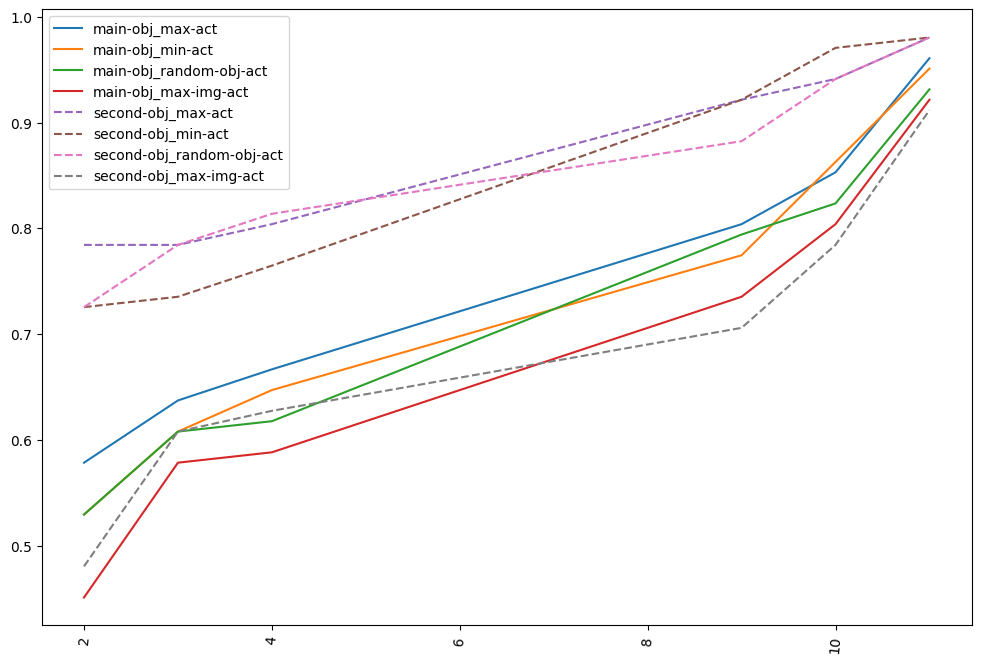

In [63]:
plt.figure(figsize=(12,8))
plt.plot(scores_pd[(scores_pd["token_strategy"]=="max_obj") & (scores_pd["object"]=="main")]["hidden_state_layer"], 
         scores_pd[(scores_pd["token_strategy"]=="max_obj") & (scores_pd["object"]=="main")]["test_score"], label="main-obj_max-act")
plt.plot(scores_pd[(scores_pd["token_strategy"]=="min_obj") & (scores_pd["object"]=="main")]["hidden_state_layer"], 
         scores_pd[(scores_pd["token_strategy"]=="min_obj") & (scores_pd["object"]=="main")]["test_score"], label="main-obj_min-act")
plt.plot(scores_pd[(scores_pd["token_strategy"]=="random_obj") & (scores_pd["object"]=="main")]["hidden_state_layer"], 
         scores_pd[(scores_pd["token_strategy"]=="random_obj") & (scores_pd["object"]=="main")]["test_score"], label="main-obj_random-obj-act")
plt.plot(scores_pd[(scores_pd["token_strategy"]=="max_image") & (scores_pd["object"]=="main")]["hidden_state_layer"], 
         scores_pd[(scores_pd["token_strategy"]=="max_image") & (scores_pd["object"]=="main")]["test_score"], label="main-obj_max-img-act")

plt.plot(scores_pd[(scores_pd["token_strategy"]=="max_obj") & (scores_pd["object"]=="second")]["hidden_state_layer"], 
         scores_pd[(scores_pd["token_strategy"]=="max_obj") & (scores_pd["object"]=="second")]["test_score"], label="second-obj_max-act", linestyle='dashed')
plt.plot(scores_pd[(scores_pd["token_strategy"]=="min_obj") & (scores_pd["object"]=="second")]["hidden_state_layer"], 
         scores_pd[(scores_pd["token_strategy"]=="min_obj") & (scores_pd["object"]=="second")]["test_score"], label="second-obj_min-act", linestyle='dashed')
plt.plot(scores_pd[(scores_pd["token_strategy"]=="random_obj") & (scores_pd["object"]=="second")]["hidden_state_layer"], 
         scores_pd[(scores_pd["token_strategy"]=="random_obj") & (scores_pd["object"]=="second")]["test_score"], label="second-obj_random-obj-act", linestyle='dashed')
plt.plot(scores_pd[(scores_pd["token_strategy"]=="max_image") & (scores_pd["object"]=="second")]["hidden_state_layer"], 
         scores_pd[(scores_pd["token_strategy"]=="max_image") & (scores_pd["object"]=="second")]["test_score"], label="second-obj_max-img-act", linestyle='dashed')

plt.xticks(rotation=85) 
plt.legend()
plt.show()

In [26]:
scores_pd.to_csv("5_class_object_decoding_closest.csv", index=False)

In [45]:
scores_pd = scores_pd.rename(columns={"test_score": "NN_test_score"})

In [47]:
scores_pd["SVM_test_score"] = list(test_scores.values())
    

In [48]:
scores_pd

,object,token_strategy,hidden_state_layer,loss,NN_test_score,SVM_test_score
0,main,consistent,10,1.624377,0.208,0.184
1,main,consistent,11,1.614972,0.194,0.180
2,main,consistent,12,1.615392,0.194,0.182
3,main,max_image,10,1.622713,0.184,0.226
4,main,max_image,11,1.603776,0.218,0.198
5,main,max_image,12,1.609430,0.206,0.222
6,main,max_obj,10,1.611561,0.206,0.204
7,main,max_obj,11,1.618591,0.186,0.200
8,main,max_obj,12,1.614495,0.172,0.178
9,main,min_obj,10,1.890197,0.190,0.202


In [49]:
scores_pd.to_csv("5_class_object_decoding_closest_svm.csv", index=False)